In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [2]:
# read the processed profilometer data
df_7s = pd.read_csv('../data/profilometer/processed/7s.csv')
df_40s = pd.read_csv('../data/profilometer/processed/40s.csv')

print("First 5 rows, 7s profile:")
display(df_7s.head())
print("First 5 rows, 40s profile:")
display(df_40s.head())


First 5 rows, 7s profile:


,Position,Height
0,0.000000,34.777488
1,0.074063,33.173748
2,0.148126,34.519985
3,0.222189,31.454984
4,0.296252,31.768328


First 5 rows, 40s profile:


,Position,Height
0,0.000000,12.225796
1,0.074063,25.662692
2,0.148126,9.528158
3,0.222189,21.604733
4,0.296252,4.803361


In [3]:
def convert_profile_to_um(df):
    df = df.copy()
    # Assuming 2nd column is the profile in Angstrom
    df['Profile (µm)'] = df.iloc[:, 1] / 10000  # 1 µm = 10,000 Å
    return df

df_7s = convert_profile_to_um(df_7s)
df_40s = convert_profile_to_um(df_40s)

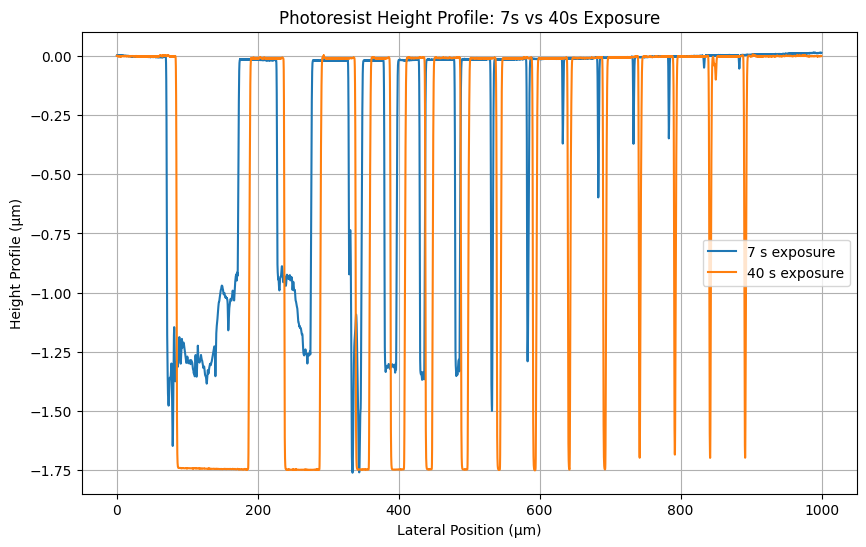

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(df_7s.iloc[:, 0], df_7s['Profile (µm)'], label='7 s exposure')
plt.plot(df_40s.iloc[:, 0], df_40s['Profile (µm)'], label='40 s exposure')
plt.xlabel('Lateral Position (µm)')
plt.ylabel('Height Profile (µm)')
plt.title('Photoresist Height Profile: 7s vs 40s Exposure')
plt.legend()
plt.grid(True)
plt.savefig(f'../results/figures/height_profile.png', dpi=300, bbox_inches='tight')
plt.show()


In [5]:
def estimate_step_height(profile):
    # Average top/bottom 10% of points
    sorted_profile = np.sort(profile)
    n = len(sorted_profile)
    low = np.mean(sorted_profile[:int(0.1 * n)])
    high = np.mean(sorted_profile[-int(0.1 * n):])
    step = high - low
    # For error estimate, std deviation of top/bottom 10%
    std = np.sqrt(np.var(sorted_profile[:int(0.1 * n)]) + np.var(sorted_profile[-int(0.1 * n):]))
    return step, low, high, std

height_7s, base_7s, top_7s, std_7s = estimate_step_height(df_7s['Profile (µm)'])
height_40s, base_40s, top_40s, std_40s = estimate_step_height(df_40s['Profile (µm)'])

print(f"7s: Step height = {height_7s:.3f} µm ± {std_7s:.3f}")
print(f"40s: Step height = {height_40s:.3f} µm ± {std_40s:.3f}")


7s: Step height = 1.355 µm ± 0.100
40s: Step height = 1.750 µm ± 0.001


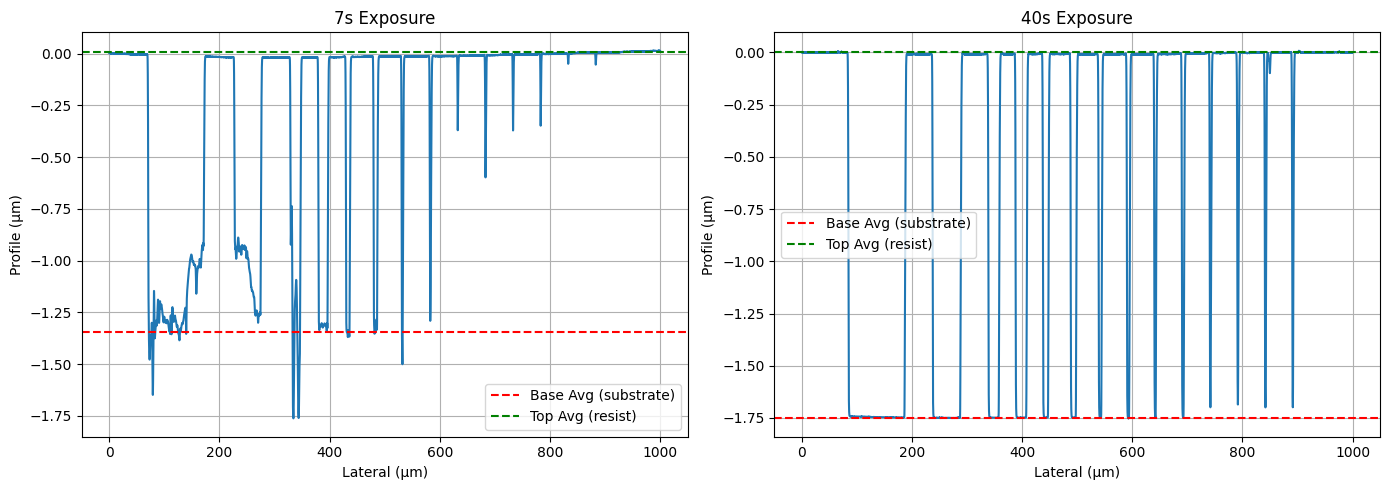

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for ax, df, exp, base, top in zip(
    axs,
    [df_7s, df_40s],
    ['7s', '40s'],
    [base_7s, base_40s],
    [top_7s, top_40s]
):
    ax.plot(df.iloc[:, 0], df['Profile (µm)'])
    ax.axhline(base, color='red', linestyle='--', label='Base Avg (substrate)')
    ax.axhline(top, color='green', linestyle='--', label='Top Avg (resist)')
    ax.set_title(f'{exp} Exposure')
    ax.set_xlabel('Lateral (µm)')
    ax.set_ylabel('Profile (µm)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig(f'../results/figures/profilometer_7s_40.png', dpi=300, bbox_inches='tight')
plt.show()


In [7]:
summary = pd.DataFrame({
    'Exposure Time (s)': [7, 40],
    'Step Height (µm)': [height_7s, height_40s],
    'Uncertainty (µm)': [std_7s, std_40s],
    'Base (µm)': [base_7s, base_40s],
    'Top (µm)': [top_7s, top_40s]
})
display(summary)
summary.to_csv('../results/tables/resist_thickness_summary.csv', index=False)
print("Summary table saved to ../results/tables/resist_thickness_summary.csv")


,Exposure Time (s),Step Height (µm),Uncertainty (µm),Base (µm),Top (µm)
0,7,1.355130,0.100264,-1.345459,0.009671
1,40,1.749888,0.001105,-1.749002,0.000886


Summary table saved to ../results/tables/resist_thickness_summary.csv


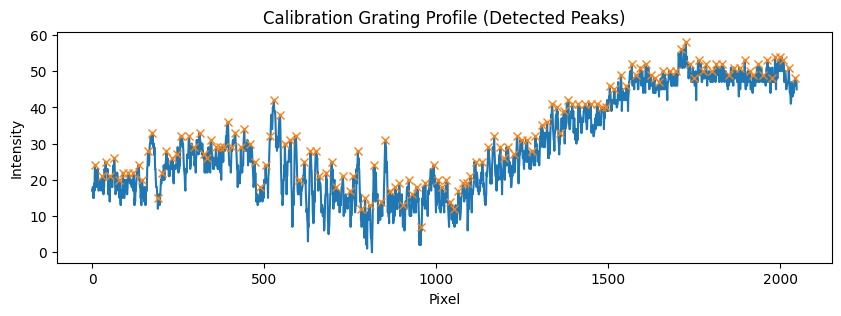

Calibration: 0.7125 µm/pixel


<Figure size 640x480 with 0 Axes>

In [23]:
# Load your calibration image
cal_img = cv2.imread('../data/images/calibration/100Lpmm_50x.jpg', cv2.IMREAD_GRAYSCALE)

# Extract a horizontal profile
cal_row = cal_img.shape[0] // 2
cal_profile = cal_img[cal_row, :]
cal_profile = np.max(cal_profile) - cal_profile  # Invert if needed

# Find grating peaks
cal_peaks, _ = find_peaks(cal_profile, distance=10)
plt.figure(figsize=(10,3))
plt.plot(cal_profile)
plt.plot(cal_peaks, cal_profile[cal_peaks], "x")
plt.title('Calibration Grating Profile (Detected Peaks)')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.show()

# Calculate microns per pixel
pixel_spacings = np.diff(cal_peaks)
mean_pixel_spacing = np.mean(pixel_spacings)
microns_per_pixel = 10.0 / mean_pixel_spacing  # 10 µm per line
plt.savefig(f'../results/figures/calibration_gating_profile.png', dpi=300, bbox_inches='tight')
print(f"Calibration: {microns_per_pixel:.4f} µm/pixel")


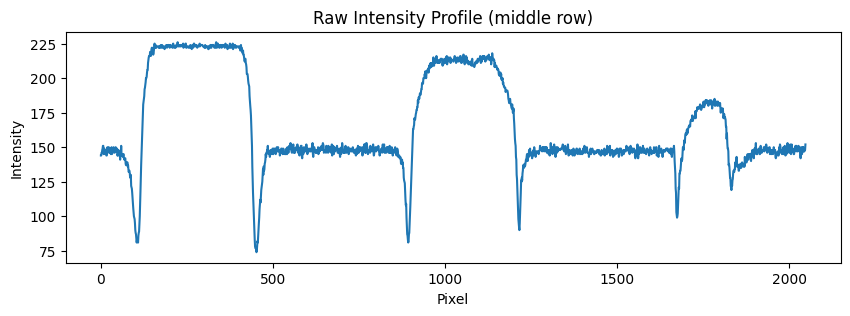

In [24]:
wafer_img = cv2.imread('../data/images/50x/40sec_ln03ln04ln05_50xnew.jpg', cv2.IMREAD_GRAYSCALE)
stripe_row = wafer_img.shape[0] // 2
stripe_profile = wafer_img[stripe_row, :]
plt.figure(figsize=(10,3))
plt.plot(stripe_profile)
plt.title('Raw Intensity Profile (middle row)')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.savefig(f'../results/figures/raw_intensity_profile.png', dpi=300, bbox_inches='tight')
plt.show()


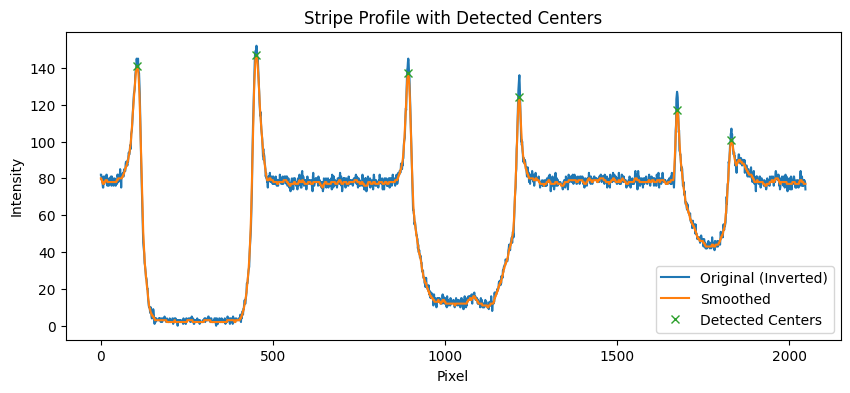

Number of detected stripe centers: 6


In [25]:
stripe_profile_inv = np.max(stripe_profile) - stripe_profile
stripe_profile_smooth = gaussian_filter1d(stripe_profile_inv, sigma=3)

stripe_peaks, _ = find_peaks(stripe_profile_smooth, distance=15, prominence=10)

plt.figure(figsize=(10, 4))
plt.plot(stripe_profile_inv, label='Original (Inverted)')
plt.plot(stripe_profile_smooth, label='Smoothed')
plt.plot(stripe_peaks, stripe_profile_smooth[stripe_peaks], "x", label='Detected Centers')
plt.title('Stripe Profile with Detected Centers')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.legend()
plt.savefig(f'../results/figures/stripe_profile_with_detected_centers.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Number of detected stripe centers: {len(stripe_peaks)}")


Stripe pitches (µm): [246.53562654 314.93857494 229.43488943 327.05159705 112.57985258]
Mean stripe pitch: 246.11 µm
Std deviation: 76.68 µm
Number measured: 5


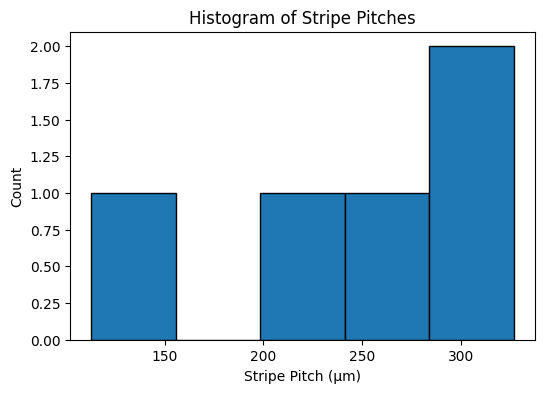

Pitch results saved to ../results/tables/wafer_stripe_pitches.csv


In [26]:
stripe_pitch_pixels = np.diff(stripe_peaks)
stripe_pitch_um = stripe_pitch_pixels * microns_per_pixel

mean_pitch = np.mean(stripe_pitch_um)
std_pitch = np.std(stripe_pitch_um)
N_pitch = len(stripe_pitch_um)

print("Stripe pitches (µm):", stripe_pitch_um)
print(f"Mean stripe pitch: {mean_pitch:.2f} µm")
print(f"Std deviation: {std_pitch:.2f} µm")
print(f"Number measured: {N_pitch}")

plt.figure(figsize=(6,4))
plt.hist(stripe_pitch_um, bins=5, edgecolor='black')
plt.xlabel('Stripe Pitch (µm)')
plt.ylabel('Count')
plt.title('Histogram of Stripe Pitches')
plt.savefig(f'../results/figures/histogram_of_stripe_pitches.png', dpi=300, bbox_inches='tight')
plt.show()

pd.DataFrame({'Stripe Pitch (µm)': stripe_pitch_um}).to_csv('../results/tables/wafer_stripe_pitches.csv', index=False)
print("Pitch results saved to ../results/tables/wafer_stripe_pitches.csv")


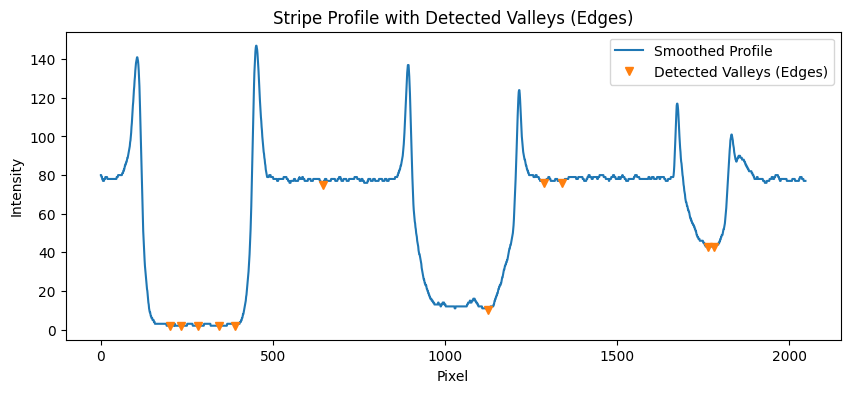

Stripe widths (µm): [ 22.08845209  35.62653563  42.03931204  33.48894349 181.6953317
 116.14250614  37.76412776  12.11302211]
Mean stripe width: 60.12 µm
Std deviation: 54.55 µm
Number measured: 8


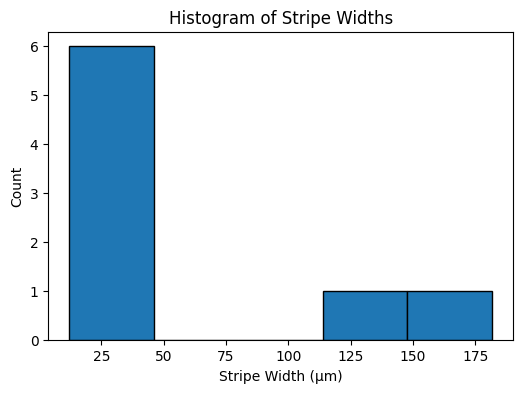

Width results saved to ../results/tables/wafer_stripe_widths.csv


In [19]:
# Find minima (valleys) as stripe edges
valley_indices, _ = find_peaks(-stripe_profile_smooth, distance=10, prominence=10)
plt.figure(figsize=(10,4))
plt.plot(stripe_profile_smooth, label='Smoothed Profile')
plt.plot(valley_indices, stripe_profile_smooth[valley_indices], "v", label='Detected Valleys (Edges)')
plt.legend()
plt.title('Stripe Profile with Detected Valleys (Edges)')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.savefig(f'../results/figures/stripe_profile.png', dpi=300, bbox_inches='tight')
plt.show()

# Each stripe is between two adjacent valleys; measure their width
stripe_width_pixels = np.diff(valley_indices)
stripe_width_um = stripe_width_pixels * microns_per_pixel

# Filter for reasonable values (ignore zero or huge widths)
stripe_width_um = stripe_width_um[(stripe_width_um > 1) & (stripe_width_um < 200)]

mean_width = np.mean(stripe_width_um)
std_width = np.std(stripe_width_um)
N_width = len(stripe_width_um)

print("Stripe widths (µm):", stripe_width_um)
print(f"Mean stripe width: {mean_width:.2f} µm")
print(f"Std deviation: {std_width:.2f} µm")
print(f"Number measured: {N_width}")

plt.figure(figsize=(6,4))
plt.hist(stripe_width_um, bins=5, edgecolor='black')
plt.xlabel('Stripe Width (µm)')
plt.ylabel('Count')
plt.title('Histogram of Stripe Widths')
plt.savefig(f'../results/figures/stripe_widths_hist.png', dpi=300, bbox_inches='tight')
plt.show()

pd.DataFrame({'Stripe Width (µm)': stripe_width_um}).to_csv('../results/tables/wafer_stripe_widths.csv', index=False)
print("Width results saved to ../results/tables/wafer_stripe_widths.csv")


In [13]:
summary = pd.DataFrame({
    'Type': ['Pitch', 'Width'],
    'Mean (µm)': [mean_pitch, mean_width],
    'Std Dev (µm)': [std_pitch, std_width],
    'N': [N_pitch, N_width]
})
display(summary)
summary.to_csv('../results/tables/wafer_stripe_summary.csv', index=False)
print("Summary table saved to ../results/tables/wafer_stripe_summary.csv")


,Type,Mean (µm),Std Dev (µm),N
0,Pitch,246.108108,76.677840,5
1,Width,60.119779,54.550424,8


Summary table saved to ../results/tables/wafer_stripe_summary.csv


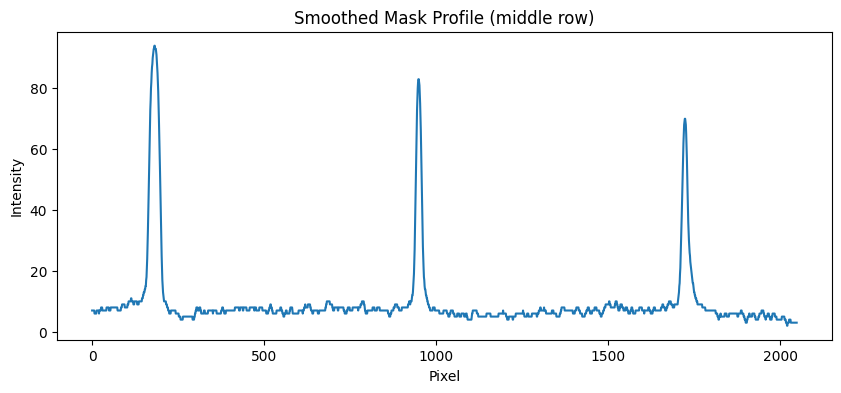

In [27]:
# Load the mask image
mask_img = cv2.imread('../data/images/50x/50x Linie121314.jpg', cv2.IMREAD_GRAYSCALE)

# Take a horizontal profile across the middle of the image
mask_row = mask_img.shape[0] // 2
mask_profile = mask_img[mask_row, :]

# Invert it
mask_profile_inv = np.max(mask_profile) - mask_profile

# Smooth the profile
mask_profile_smooth = gaussian_filter1d(mask_profile_inv, sigma=3)

# Plot the smoothed profile
plt.figure(figsize=(10, 4))
plt.plot(mask_profile_smooth)
plt.title('Smoothed Mask Profile (middle row)')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.savefig(f'../results/figures/smoothed_mask_profile.png', dpi=300, bbox_inches='tight')
plt.show()


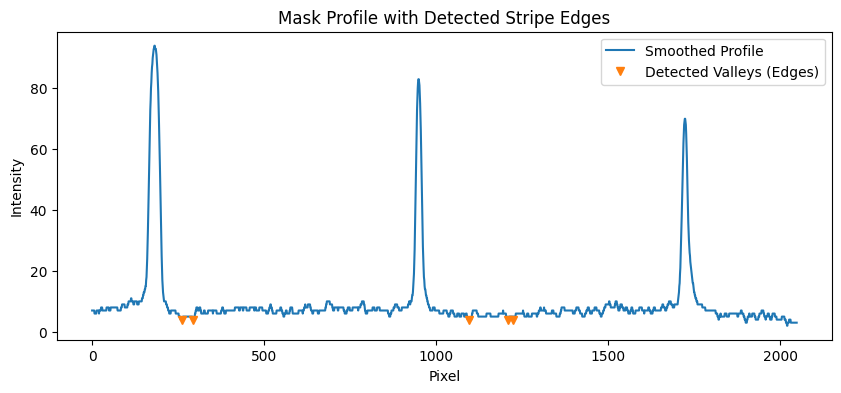

Mask stripe widths (µm): [24.22604423 79.8034398   9.97542998]
Mean mask stripe width: 38.00 µm
Std deviation: 30.13 µm
Number measured: 3


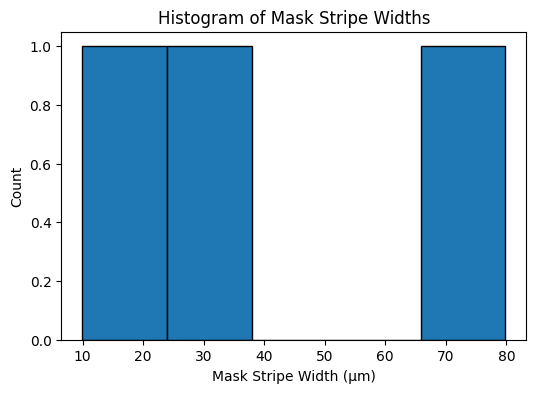

Mask width results saved to ../results/tables/mask_stripe_widths.csv


In [28]:
# Find stripe edges (valleys)
mask_valleys, _ = find_peaks(-mask_profile_smooth, distance=10, prominence=10)

plt.figure(figsize=(10, 4))
plt.plot(mask_profile_smooth, label='Smoothed Profile')
plt.plot(mask_valleys, mask_profile_smooth[mask_valleys], "v", label='Detected Valleys (Edges)')
plt.legend()
plt.title('Mask Profile with Detected Stripe Edges')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.savefig(f'../results/figures/mask_rofile_with_detected_stripe_edges.png', dpi=300, bbox_inches='tight')
plt.show()

# Measure stripe widths (distance between adjacent valleys)
mask_width_pixels = np.diff(mask_valleys)
mask_width_um = mask_width_pixels * microns_per_pixel

# Filter plausible values
mask_width_um = mask_width_um[(mask_width_um > 1) & (mask_width_um < 200)]

mean_mask_width = np.mean(mask_width_um)
std_mask_width = np.std(mask_width_um)
N_mask = len(mask_width_um)

print("Mask stripe widths (µm):", mask_width_um)
print(f"Mean mask stripe width: {mean_mask_width:.2f} µm")
print(f"Std deviation: {std_mask_width:.2f} µm")
print(f"Number measured: {N_mask}")

# Histogram
plt.figure(figsize=(6,4))
plt.hist(mask_width_um, bins=5, edgecolor='black')
plt.xlabel('Mask Stripe Width (µm)')
plt.ylabel('Count')
plt.title('Histogram of Mask Stripe Widths')
plt.savefig(f'../results/figures/mask_stripe_widths_hist.png', dpi=300, bbox_inches='tight')
plt.show()

# Save to CSV
pd.DataFrame({'Mask Stripe Width (µm)': mask_width_um}).to_csv('../results/tables/mask_stripe_widths.csv', index=False)
print("Mask width results saved to ../results/tables/mask_stripe_widths.csv")


In [16]:
# Reuse your wafer results: mean_width, std_width, N_width
comparison = pd.DataFrame({
    'Sample': ['Mask', 'Wafer'],
    'Mean Stripe Width (µm)': [mean_mask_width, mean_width],
    'Std Dev (µm)': [std_mask_width, std_width],
    'N': [N_mask, N_width]
})

comparison['Percent Difference (%)'] = 100 * (comparison['Mean Stripe Width (µm)'][1] - comparison['Mean Stripe Width (µm)'][0]) / comparison['Mean Stripe Width (µm)'][0]

display(comparison)
comparison.to_csv('../results/tables/mask_vs_wafer_widths.csv', index=False)
print("Comparison table saved to ../results/tables/mask_vs_wafer_widths.csv")


,Sample,Mean Stripe Width (µm),Std Dev (µm),N,Percent Difference (%)
0,Mask,38.001638,30.125438,3,58.203125
1,Wafer,60.119779,54.550424,8,58.203125


Comparison table saved to ../results/tables/mask_vs_wafer_widths.csv


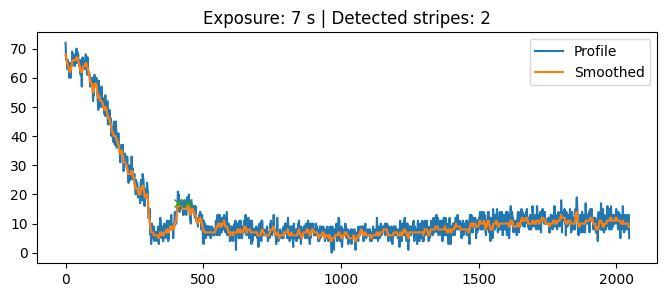

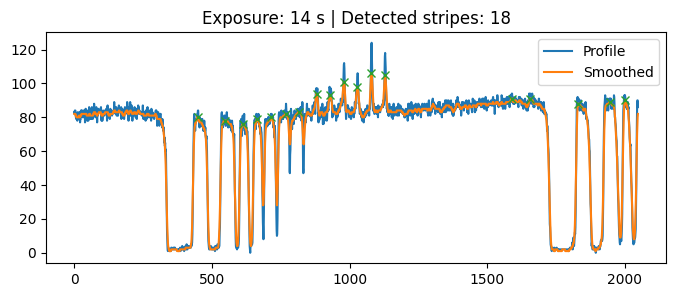

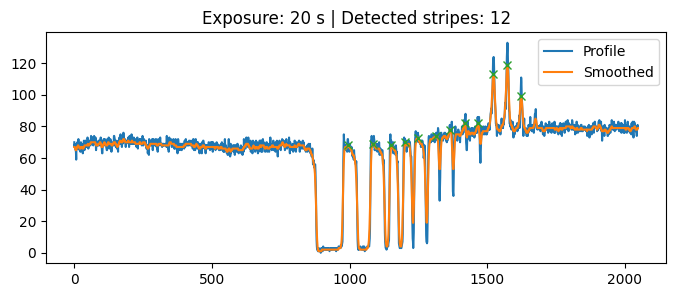

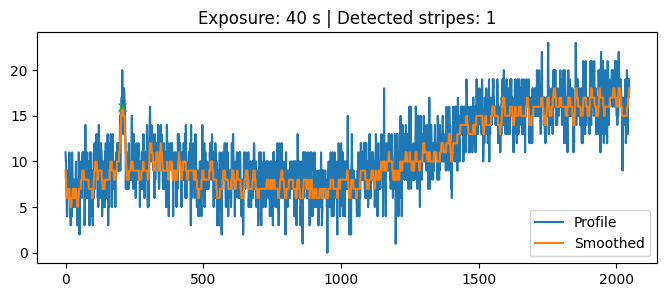

Exposure 7 s: 2 developed stripes
Exposure 14 s: 18 developed stripes
Exposure 20 s: 12 developed stripes
Exposure 40 s: 1 developed stripes


In [18]:
import cv2
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Update with your file paths
image_files = [
    '../data/images/3p2x/7sec_3p2x.jpg',
    '../data/images/3p2x/14sec_3p2x.jpg',
    '../data/images/3p2x/20sec_3p2x.jpg',
    '../data/images/3p2x/40sec_3p2x.jpg'
]
exposure_times = [7, 14, 20, 40]
developed_stripes = []

for img_file, dose in zip(image_files, exposure_times):
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    # Pick a central horizontal line profile
    stripe_row = img.shape[0] // 2
    profile = img[stripe_row, :]
    # Invert if stripes are bright (so stripes are peaks)
    profile = np.max(profile) - profile
    
    # Smooth to reduce noise (optional)
    from scipy.ndimage import gaussian_filter1d
    profile_smooth = gaussian_filter1d(profile, sigma=3)
    
    # Peak finding: tweak distance/prominence as needed for your image
    peaks, _ = find_peaks(profile_smooth, distance=20, prominence=10)
    
    # Plot for sanity check
    plt.figure(figsize=(8,3))
    plt.title(f'Exposure: {dose} s | Detected stripes: {len(peaks)}')
    plt.plot(profile, label='Profile')
    plt.plot(profile_smooth, label='Smoothed')
    plt.plot(peaks, profile_smooth[peaks], 'x')
    plt.legend()
    plt.savefig(f'../results/figures/profile_{dose}s.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Store count
    developed_stripes.append(len(peaks))

# Print result as a table
for dose, count in zip(exposure_times, developed_stripes):
    print(f"Exposure {dose} s: {count} developed stripes")
